# Notebook 02: Análisis Exploratorio de Datos (EDA)

## Índice 
1. [Objetivo](#objetivo)
2. [Carga de Datos](#carga)
3. [Análisis Univariado](#univariado)
   - 3.1 [Distribuciones](#distribuciones)
   - 3.2 [Outliers (Boxplots)](#outliers)
4. [Análisis Bivariado](#bivariado)
   - 4.1 [Correlaciones](#correlaciones)
   - 4.2 [Features vs Target](#features-target)
5. [Análisis Multivariado](#ultivariado)
   - 5.1 [Pair PLots](#pairplots)
   - 5.2 [Segmentación por Diabétes](#segmentacion)
6. [Insights Clave](#insights)
7. [Conclusiones](#conclusiones)

## Objetivo {#objetivo}

**¿Qué hacemos en este notebook?**
- Explorar profundamente cada variable del dataset
- Entender relaciones entre variables
- Identificar patrones que diferencian entre diabéticas de no diabéticas
- Generar hipótesis para feature engineering
- Crear visualizaciones profecionales para reportes

**¿Por qué es crítico el EDA?**
> "Garbage in, garbage out" - Si no entiendes tus datos, tu modelo será malo

- El EDA revela problemas de calidad que deberian corregirse
- Identifica variables predictivas vs irrelevantes
- Inspira features nuevas que mejoran performance
- Justuduca decisiones de preprocesamiento

**Entregables:**
- 20+ visualizaciones guardadas en "reports/figures/"
- Análisis estadístico completo
- Lista de insights accionables
- Recomendaciones para próximos pasos
  

In [1]:
# Manipulación de datos 
import pandas as pd
import numpy as np

# Visualización 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

# Estadística 
from scipy import stats
from scipy.stats import chi2_contingency, normaltest, shapiro

#Utilidades
import warnings
from pathlib import Path

#Configuración 
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)

# Configuración visual profecional 
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Crae directorio para figuras si no existe
FIGURES_DIR = Path('../reports/figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

## Carga de Datos {#carga}

In [2]:
# Cargar datos desde el notebook anterior 
df = pd.read_csv('../data/raw/diabetes.csv')

# Verificar
display(df.head(3))

# Separar features y target para análisis
features = df.drop("Outcome", axis=1)
target = df["Outcome"]

print(f'Features: {features.shape[1]}, Target: {target.name}')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


Features: 8, Target: Outcome


## 3. Análisis Univariado {#univariado}

Analizaremos cada variable individualmente para entender:
- **Forma de la distribución:** normal, sesgada, bimodal
- **Valores centrales:** media, mediana, moda
- **Dispersión:** rango, desviación estándar, IQR
- **Outliers:** valores extremos
- **Valores anómalos:** ceros imposibles, missing codificados
   

### 3.1 Distribuciones de Variables {#distribuciones}


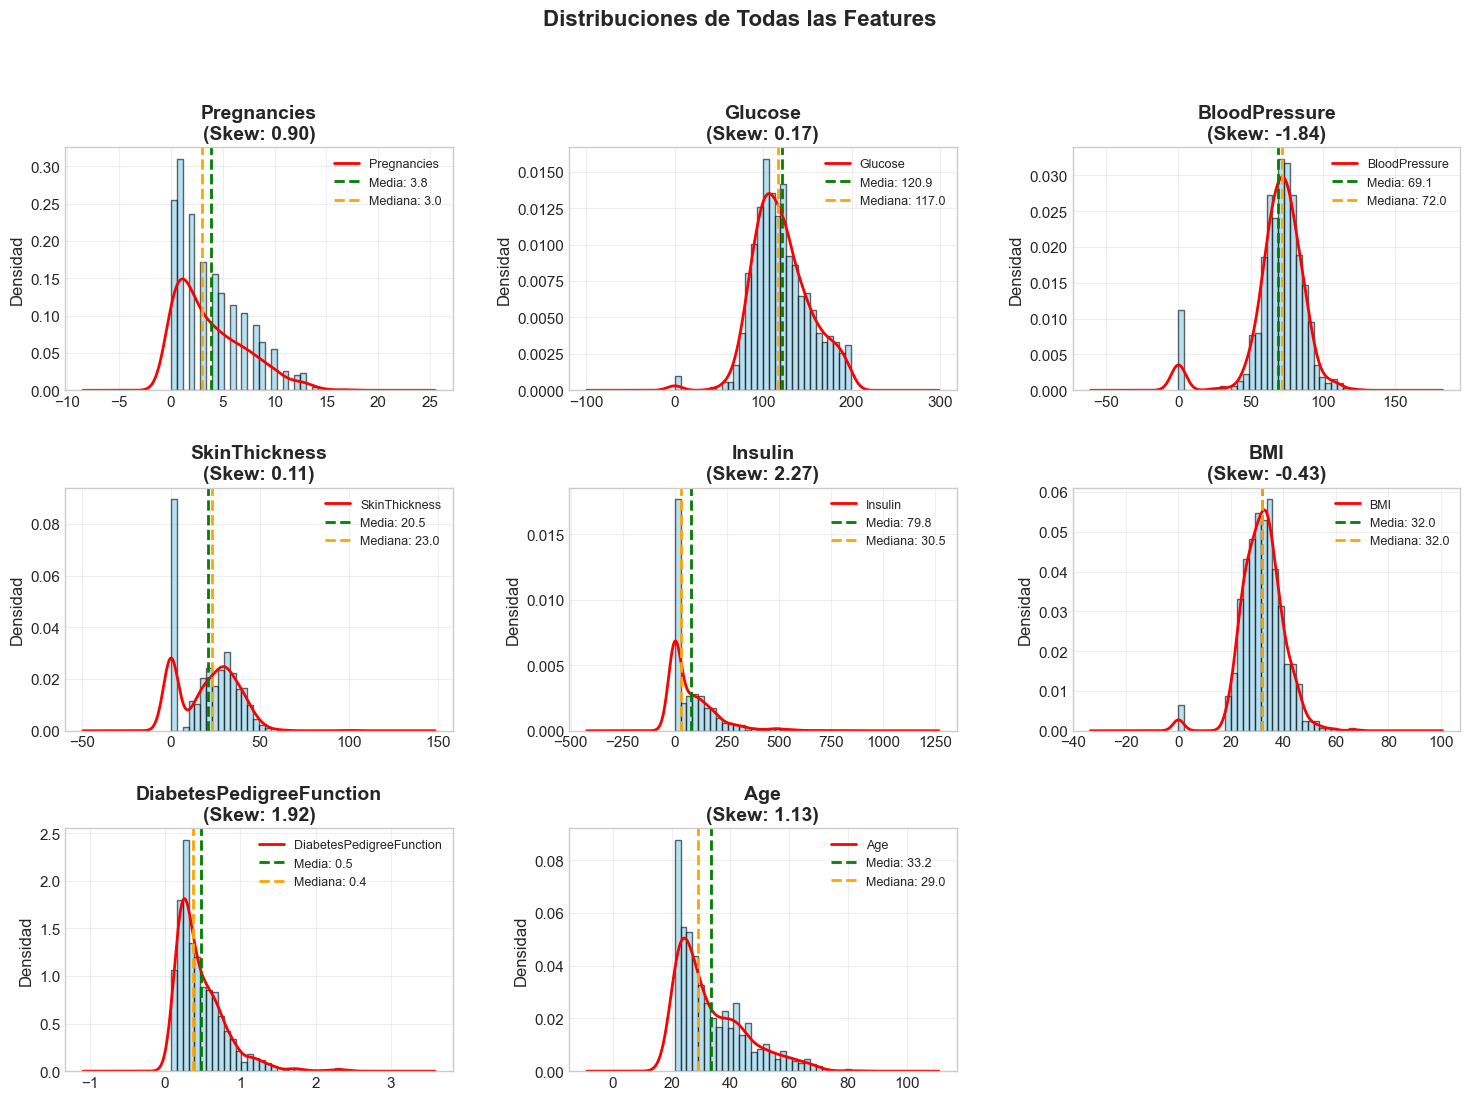

Gafrico guardado correctamente


In [3]:
fig = plt.figure(figsize=(18,12))
gs = GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.3)

for idx, col in enumerate(features.columns):
    ax = fig.add_subplot(gs[idx // 3, idx % 3])

    # Histograma con KDE
    ax.hist(df[col], bins=30, alpha=0.6, color="skyblue", edgecolor="black", density=True)

    # Superponer curva KDE
    df[col].plot(kind="kde", ax=ax, color="red", linewidth=2)

    # Lineas de referencia (media y mediana)
    mean_val = df[col].mean()
    median_val = df[col].median()

    ax.axvline(mean_val, color="green", linestyle="--", linewidth=2, label=f'Media: {mean_val:.1f}')
    ax.axvline(median_val, color="orange", linestyle="--", linewidth=2, label=f'Mediana: {median_val:.1f}')

    # Etiquetas y título
    ax.set_title(f'{col}\n(Skew: {df[col].skew():.2f})', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Densidad')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Distribuciones de Todas las Features', fontsize=16, fontweight='bold', y=0.995)
plt.savefig(FIGURES_DIR / '02_distributions_all_features.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gafrico guardado correctamente')


### Interpretación de Distribuciones

**Qué buscar en cada gráfico:**
1. **Forma (Skewness):**
   - 'Skew = 0': Distribución simétrica (normal)
   - 'Skew > 0': Sesgada a la derecha (cola larga a la derecha) -> mayoria valores bajos
   - 'Skew < 0': Sesgada a la izquierda (cola larga a la izquierda) -> mayoria valores altos
2. **Media vs Mediana:**
   - Si 'Media = Mediana' -> distribución simétrica
   - Si 'media > Mediana' -> sesgo derecho (outliers altos jalan la media)
   - Si 'media < Mediana' -> sesgo izquierdo
3. **Múltiples picos (Bimodal/Multimodal):**
   - Sugiere subpoblaciones diferentes
   - Ej: Si Glucose tiene 2 picos -> diabéticas vs no diabéticas

In [4]:
# ANÁLISIS DE SKEWNESS Y NORMALIDAD 

print('ANÁLISIS DE FORMA DE DISTRIBUCIONES')

normality_results = []
for col in features.columns:
    #Calcular skewness y kurtosis
    skew = df[col].skew()
    kurt = df[col].kurtosis()

    #Test de normalidad (Shapiro-Wilk)
    #HO: Los datos provienen de una distribución normal
    stat, p_value = shapiro(df[col].dropna())
    is_normal = "Normal" if p_value > 0.05 else "No Normal"

    # Clasificar distribución 
    if abs(skew) < 0.5:
        dist_type = "Simetrica"
    elif skew > 0.5:
        dist_type = "Sesgada Derecha"
    else:
        dist_type = "Sesgada Izquierda"

    normality_results.append({
        "Variable": col,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Shapiro p-value": p_value,
        "Normalidad": is_normal,
        "Tipo Distribución": dist_type
    })

df_normality = pd.DataFrame(normality_results)
display(df_normality.style.background_gradient(subset=['Skewness', 'Kurtosis'], cmap='coolwarm'))

ANÁLISIS DE FORMA DE DISTRIBUCIONES


,Variable,Skewness,Kurtosis,Shapiro p-value,Normalidad,Tipo Distribución
0,Pregnancies,0.901674,0.159220,0.000000,No Normal,Sesgada Derecha
1,Glucose,0.173754,0.640780,0.000000,No Normal,Simetrica
2,BloodPressure,-1.843608,5.180157,0.000000,No Normal,Sesgada Izquierda
3,SkinThickness,0.109372,-0.520072,0.000000,No Normal,Simetrica
4,Insulin,2.272251,7.214260,0.000000,No Normal,Sesgada Derecha
5,BMI,-0.428982,3.290443,0.000000,No Normal,Simetrica
6,DiabetesPedigreeFunction,1.919911,5.594954,0.000000,No Normal,Sesgada Derecha
7,Age,1.129597,0.643159,0.000000,No Normal,Sesgada Derecha


In [5]:
print('INSIGHT: Ninguna variable sigue una distribución perfectamente normal')
print('-> Transformaiones (log, sqrt) podrian mejorar performance de modelos lineales')

INSIGHT: Ninguna variable sigue una distribución perfectamente normal
-> Transformaiones (log, sqrt) podrian mejorar performance de modelos lineales


### 3.2 Detección de Outliers con Boxplots {#outliers}

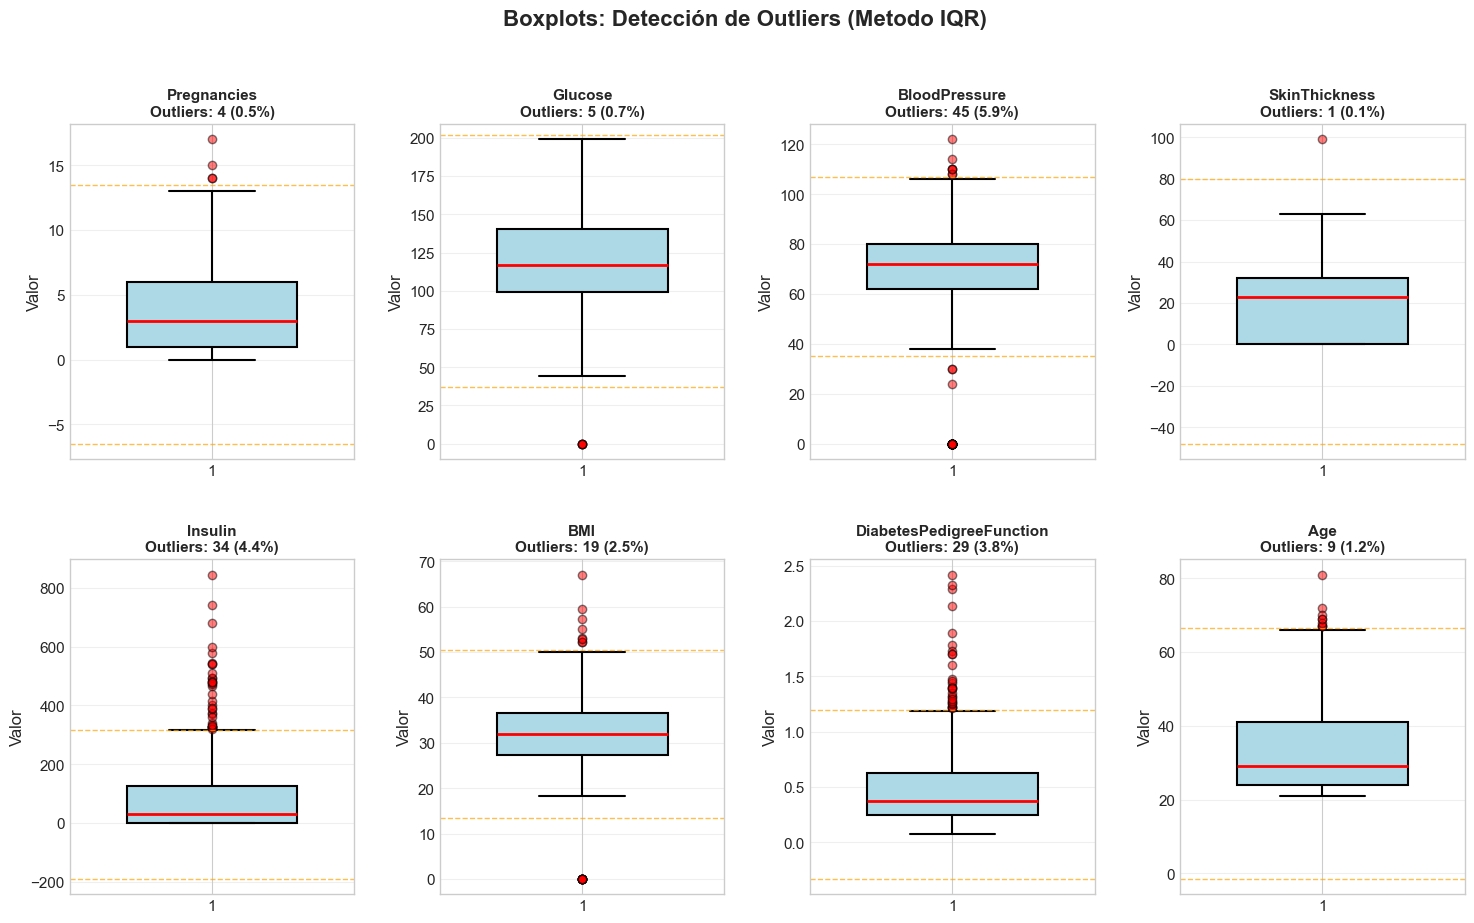

In [6]:
# BOXPLOTS PARA DETECTAR OUTLIERS

fig = plt.figure(figsize=(18,10))
gs = GridSpec(2,4, figure=fig, hspace=0.3, wspace=0.3)

for idx, col in enumerate(features.columns):
    ax = fig.add_subplot(gs[idx // 4, idx % 4])

    # Boxplot con paleta de colores
    bp = ax.boxplot(df[col], vert=True, patch_artist=True, widths=0.6,
                    boxprops=dict(facecolor="lightblue", edgecolor="black", linewidth=1.5),
                    whiskerprops=dict(color="black", linewidth=1.5),
                    capprops=dict(color="black", linewidth=1.5),
                    medianprops=dict(color="red", linewidth=2),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=6, alpha=0.5)
                   )

    # Calcular IQR y outliers
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    n_outliers = len(outliers)

    #Titulo con info
    ax.set_title(f'{col}\nOutliers: {n_outliers} ({n_outliers/len(df)*100:.1f}%)',
                fontweight="bold", fontsize=11)
    ax.set_ylabel("Valor")
    ax.grid(axis='y', alpha=0.3)

    # Agregar lineas de referencia 
    ax.axhline(y=lower_bound, color='orange', linestyle='--', linewidth=1, alpha=0.7)
    ax.axhline(y=upper_bound, color='orange', linestyle='--', linewidth=1, alpha=0.7)

plt.suptitle('Boxplots: Detección de Outliers (Metodo IQR)', fontsize=16, fontweight='bold', y=0.995)
plt.savefig(FIGURES_DIR / '02_boxplots_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

### Problema Crítico: Valores Cero como Missing

Notebook 01: Ciertas variables tienen **ceros biológicamente imposibles**.
Estos son valores faltantes mal codificados.

In [7]:
print("VALORES CERO (POSIBLES MISSING CODIFICADOS)")

cannot_be_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

zero_analysis = []
for col in cannot_be_zero:
    zeros = (df[col] == 0).sum()
    pct = (zeros / len(df) * 100)
    zero_analysis.append({
        "Variable": col,
        "Ceros": zeros,
        "% Ceros": pct,
        "Valor Minimo": df[df[col] > 0][col].min() if (df[col] > 0).any() else 0,
        "Media (sin ceros)": df[df[col] > 0][col].mean() if (df[col] > 0).any() else 0
    })

df_zeros = pd.DataFrame(zero_analysis).sort_values("Ceros", ascending=False)
display(df_zeros.style.background_gradient(subset=["Ceros", "% Ceros"], cmap="Oranges"))

VALORES CERO (POSIBLES MISSING CODIFICADOS)


,Variable,Ceros,% Ceros,Valor Minimo,Media (sin ceros)
3,Insulin,374,48.697917,14.000000,155.548223
2,SkinThickness,227,29.557292,7.000000,29.153420
1,BloodPressure,35,4.557292,24.000000,72.405184
4,BMI,11,1.432292,18.200000,32.457464
0,Glucose,5,0.651042,44.000000,121.686763


In [8]:
print("CONCLUCIÓN:")
print("Insulin: 48.7% son ceros -> Problema grave de missing data")
print("SkinThickness: 29.6% son ceros")
print("BloodPressure: 4.6% son ceros")
print("ACCIÓN REQUERIDA EN PROXIMO NOTEBOOK:")
print("1. Reemplazar ceros -> NaN en estas variables")
print("2. Aplicar inputación inteligente (media,mediana,KNN,etc.)")

CONCLUCIÓN:
Insulin: 48.7% son ceros -> Problema grave de missing data
SkinThickness: 29.6% son ceros
BloodPressure: 4.6% son ceros
ACCIÓN REQUERIDA EN PROXIMO NOTEBOOK:
1. Reemplazar ceros -> NaN en estas variables
2. Aplicar inputación inteligente (media,mediana,KNN,etc.)


## 4. Análisis Bivariado {#bivariado}
Ahora exploramos **relaciones entre variables**

### 4.1 Matriz de Correlación {#correlaciones}

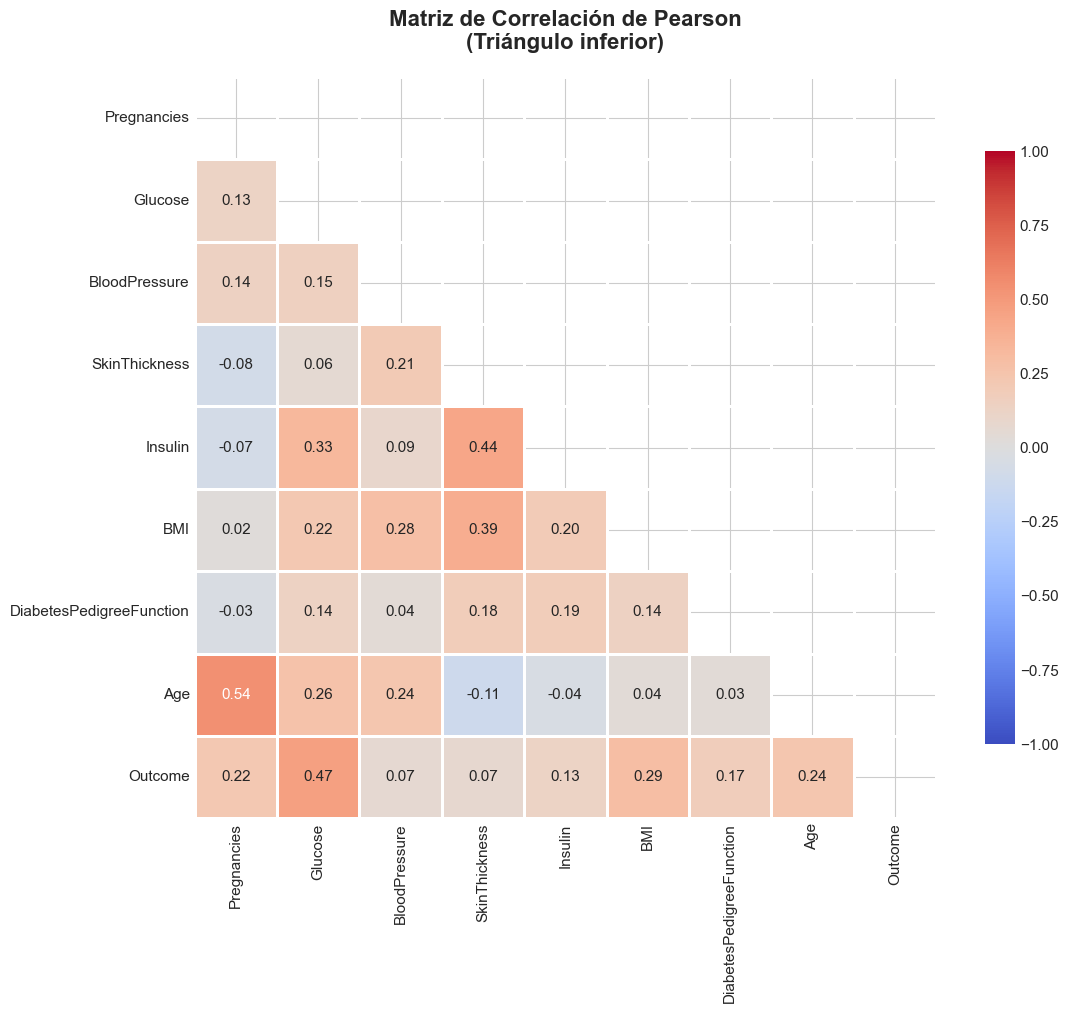

In [9]:
#HEATMAP DE CORRELACIONES

# Calcular matriz de correlación (Pearson)
corr_matrix = df.corr()

# Crear máscara para triángulo superior (evita duplicación)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Crear figura
fig, ax = plt.subplots(figsize=(12,10))

# Heatmap con Seaborn
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
           center=0, square=True, linewidths=1, cbar_kws={"shrink":0.8},
           vmin=-1, vmax=1, ax=ax)

ax.set_title("Matriz de Correlación de Pearson\n(Triángulo inferior)",fontsize=16, fontweight="bold", pad=20)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "02_correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

CORRELACIONES CON OUTCOME (DIABETES)
Correlación de cada feature con Diabetes:
🟡 Glucose                  : +0.467 (Moderada)
🔵 BMI                      : +0.293 (Débil)
🔵 Age                      : +0.238 (Débil)
🔵 Pregnancies              : +0.222 (Débil)
🔵 DiabetesPedigreeFunction : +0.174 (Débil)
🔵 Insulin                  : +0.131 (Débil)
⚪ SkinThickness            : +0.075 (Muy débil)
⚪ BloodPressure            : +0.065 (Muy débil)


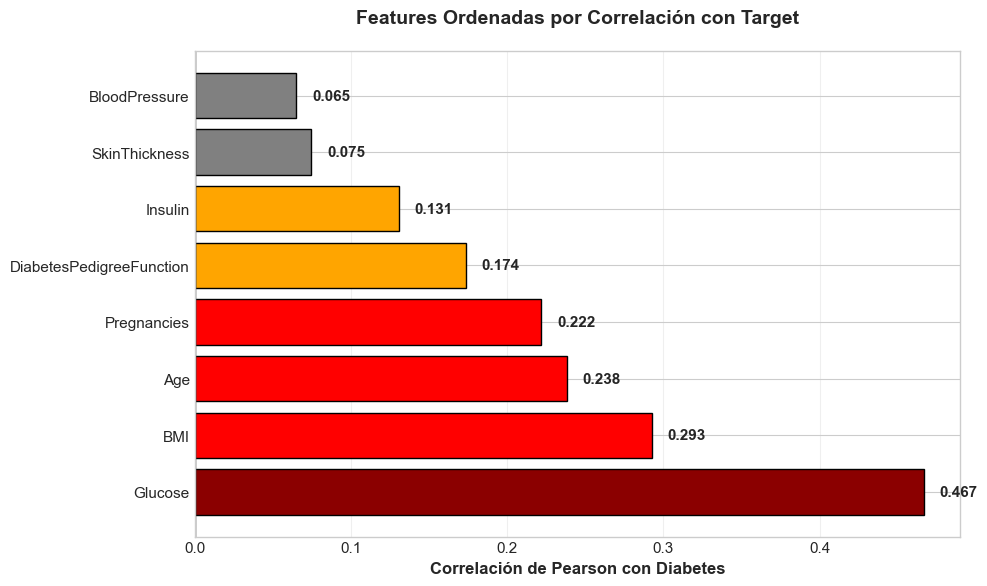

In [10]:
# CORRELACIONES MÁS FUERTES CON TARGET (OUTCOME)

print("CORRELACIONES CON OUTCOME (DIABETES)")

# Correlaciones con target
target_corr = corr_matrix["Outcome"].drop("Outcome").sort_values(ascending=False)

print("Correlación de cada feature con Diabetes:")
for feat, corr_val in target_corr.items():
    #Interpretar fuerza
    if abs(corr_val) < 0.1:
        strength = "Muy débil"
        emoji = "⚪"
    elif abs(corr_val) < 0.3:
        strength = "Débil"
        emoji = "🔵"
    elif abs(corr_val) < 0.5:
        strength = "Moderada"
        emoji = "🟡"
    else:
        strength = "Fuerte"
        emoji = "🔴"

    print(f'{emoji} {feat:25s}: {corr_val:+.3f} ({strength})')


# Visualización 
fig, ax = plt.subplots(figsize=(10,6))
colors = ["darkred" if x > 0.3 else "red" if x > 0.2 else "orange" if x > 0.1 else "gray"
         for x in target_corr.values]
bars = ax.barh(target_corr.index, target_corr.values, color=colors, edgecolor="black", linewidth=1)
ax.set_xlabel("Correlación de Pearson con Diabetes", fontsize=12, fontweight="bold")
ax.set_title("Features Ordenadas por Correlación con Target", fontsize=14, fontweight="bold", pad=20)
ax.axvline(x=0, color="black", linewidth=1)
ax.grid(axis="x", alpha=0.3)

# Agregar valores
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01 if width > 0 else width - 0.01, bar.get_y() + bar.get_height()/2, 
           f'{width:.3f}', ha="left" if width > 0 else "right", va="center", fontweight="bold")

plt.tight_layout()
plt.savefig(FIGURES_DIR / '02_correlations_with_target.png', dpi=300, bbox_inches='tight')
plt.show()

### INSIGHTS DE CORRELACIONES

**Top 3 Predictores (Mayor correlación con Diabétes):**

1. **Glucose(0.47)**: La glucosa es el predictor mas fuerte
   - Esperado: diabétes se diagnostica con niveles de glucosa 
   - Correlación moderada-fuerte
2. **BMI (0.29)**: Obecidad es un factor de riesgo conocido
   - Correlación moderada-débil
   - No es determinante por si solo
3. **Age (0.24)**: Riesgo aumenta con la edad
   - Correlación debil-moderada
  
**Correlaciones Bajas (<0.2)**:
- BloodPressure, SkinThickness, Insulin
- NO significa que sean inútiles (correlación lineal ≠ predictibilidad total)
- Modelos no lineales (RF, XGBoost= podrian capturar relaciones complejas

**Correlaciones entre Features:**
- Age <-> Pregnancies (0.54): Normal, más edad -> más embarazos
- Insulin <-> SkinThickness (0.44): Relación fisiológica
- Ninguna multicolinealidad severa (todas <0.8)

### 4.2 Features vs Target (Distribuciones Comparadas) {#features-target}


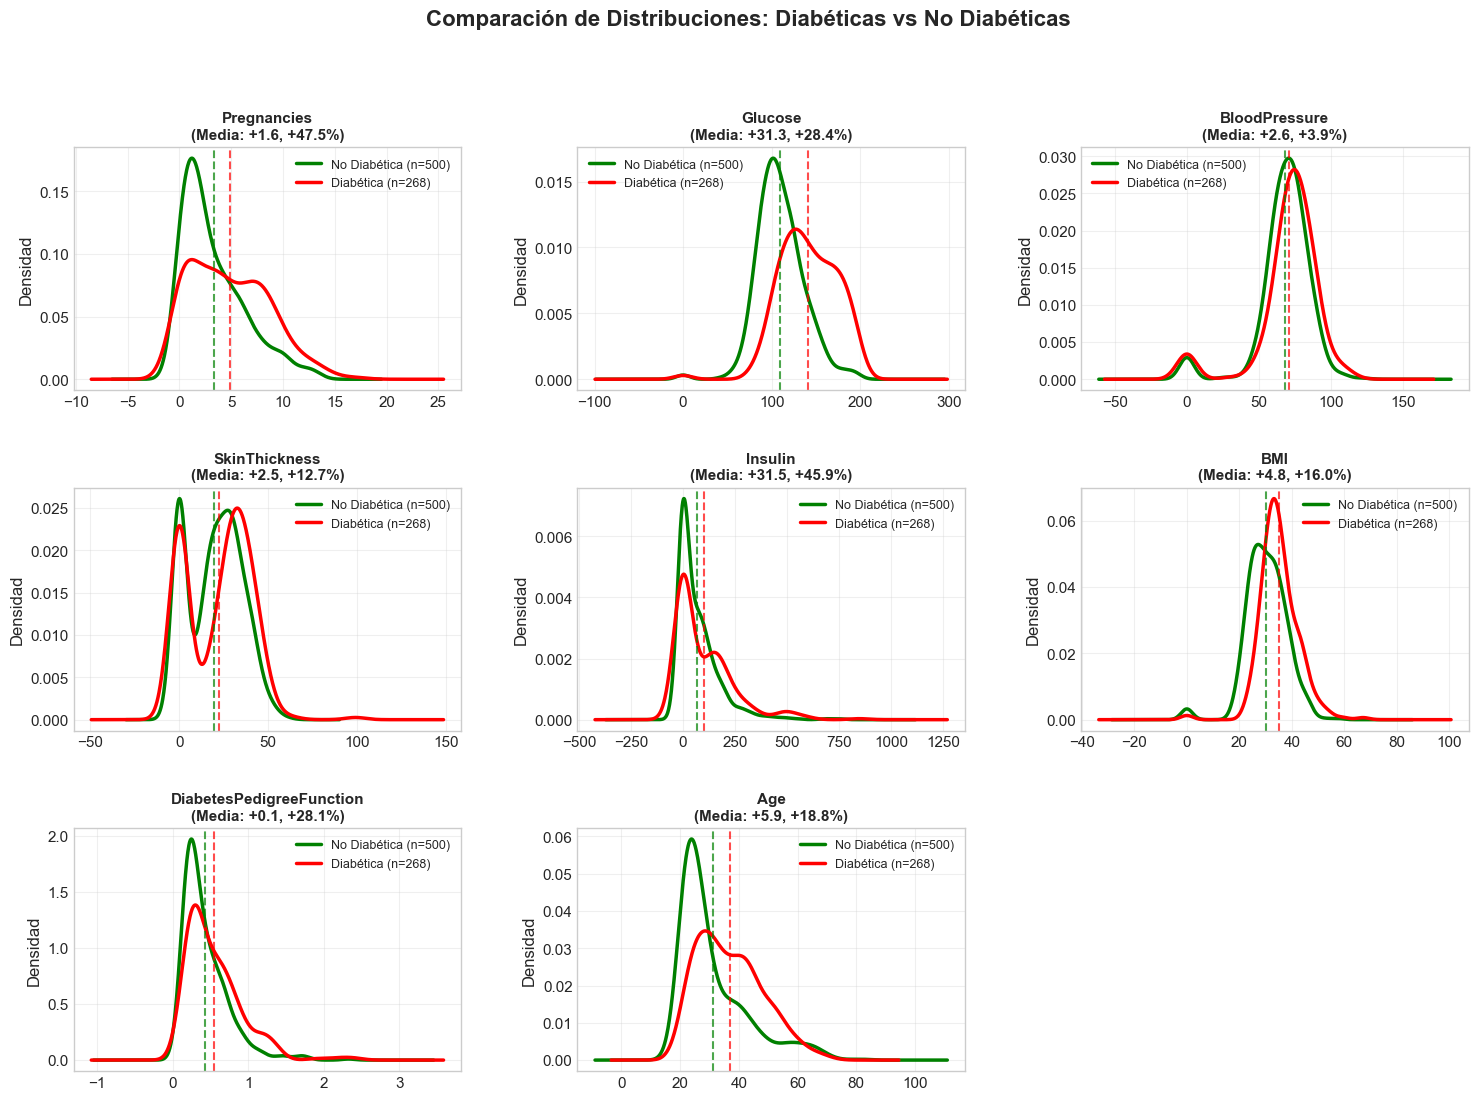

In [11]:
# DISTRIBUCIONES POR CLASE (DIABÉTICA VS NO DIABÉTICA)

fig = plt.figure(figsize=(18,12))
gs = GridSpec(3,3, figure=fig, hspace=0.4, wspace=0.3)

for idx, col in enumerate(features.columns):
    ax = fig.add_subplot(gs[idx // 3, idx % 3])

    # Separar por outcome
    no_diabetes = df[df["Outcome"] == 0][col]
    si_diabetes = df[df["Outcome"] == 1][col]

    #KDE para cada grupo
    no_diabetes.plot(kind="kde", ax=ax, color="green", linewidth="2.5",
                    label=f'No Diabética (n={len(no_diabetes)})')
    si_diabetes.plot(kind="kde", ax=ax, color="red", linewidth="2.5",
                    label=f'Diabética (n={len(si_diabetes)})')

    # Medias de cada grupo
    ax.axvline(no_diabetes.mean(), color="green", linestyle="--", linewidth=1.5, alpha=0.7)
    ax.axvline(si_diabetes.mean(), color="red", linestyle="--", linewidth=1.5, alpha=0.7)

    # Titulo y etiquetas
    mean_diff = si_diabetes.mean() - no_diabetes.mean()
    pct_diff = (mean_diff / no_diabetes.mean() * 100)

    ax.set_title(f'{col}\n(Media: {mean_diff:+.1f}, {pct_diff:+.1f}%)',
                fontweight="bold", fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("Densidad")
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle("Comparación de Distribuciones: Diabéticas vs No Diabéticas",
            fontsize=16, fontweight="bold", y=0.995)
plt.savefig(FIGURES_DIR / "02_distributions_by_outcome.png", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
# ¿LAS MEDIAS SON SIGNIFICATIVAMENTE DIFERENTES?

print("TEST T-STUDENT: DIFERENCIA DE MEDIAS POR GRUPO")
print("HO: Las medias de diabéticas y no diabéticas son iguales")
print("Ha: Las medias son diferentes")

stat_tests = []

for col in features.columns:
    no_diabetes = df[df["Outcome"] == 0][col]
    si_diabetes = df[df["Outcome"] == 1][col]

    # T-test independiante
    t_stat, p_value = stats.ttest_ind(no_diabetes, si_diabetes)

    # Calcular effect size (Cohen´s d)
    pooled_std = np.sqrt(((len(no_diabetes) - 1)*no_diabetes.std()**2 + 
                         (len(si_diabetes) - 1)*si_diabetes.std()**2) /
                        (len(no_diabetes) + len(si_diabetes)- 2))

    cohens_d = (si_diabetes.mean() - no_diabetes.mean()) / pooled_std


    # Interpretar
    significance = "Significativa" if p_value < 0.5 else "No Significativa"

    if abs(cohens_d) < 0.2:
        effect = "Pequeño"
    elif abs(cohens_d) < 0.5:
        effect = "Mediano"
    else:
        effect = "Grande"

    stat_tests.append({
        "Variable": col,
        "Media No-Diabetes": no_diabetes.mean(),
        "Media Diabetes": si_diabetes.mean(),
        "Diferencia": si_diabetes.mean() - no_diabetes.mean(),
        "p-value":p_value,
        "Significancia":significance,
        "Cohen's d":cohens_d,
        "Tamaño Efecto":effect
    })

df_tests = pd.DataFrame(stat_tests).sort_values("p-value")
display(df_tests.style.background_gradient(subset=['p-value', "Cohen's d"], cmap='RdYlGn_r'))



TEST T-STUDENT: DIFERENCIA DE MEDIAS POR GRUPO
HO: Las medias de diabéticas y no diabéticas son iguales
Ha: Las medias son diferentes


,Variable,Media No-Diabetes,Media Diabetes,Diferencia,p-value,Significancia,Cohen's d,Tamaño Efecto
1,Glucose,109.980000,141.257463,31.277463,0.000000,Significativa,1.105307,Grande
5,BMI,30.304200,35.142537,4.838337,0.000000,Significativa,0.641366,Grande
7,Age,31.190000,37.067164,5.877164,0.000000,Significativa,0.514245,Grande
0,Pregnancies,3.298000,4.865672,1.567672,0.000000,Significativa,0.476827,Mediano
6,DiabetesPedigreeFunction,0.429734,0.550500,0.120766,0.000001,Significativa,0.369885,Mediano
4,Insulin,68.792000,100.335821,31.543821,0.000286,Significativa,0.275896,Mediano
3,SkinThickness,19.664000,22.164179,2.500179,0.038348,Significativa,0.157066,Pequeño
2,BloodPressure,68.184000,70.824627,2.640627,0.071514,Significativa,0.136626,Pequeño


In [17]:
print("CONCLUCIÓN:")
sig_vars = df_tests[df_test["p-value"] < 0.5]["Variable"].tolist()
print(f"   • {len(sig_vars)}/8 variables tienen diferencias significativas entre grupos")
print(f"   • Variables significativas: {', '.join(sig_vars)}")
print(f"   • Glucose tiene el mayor tamaño de efecto (Cohen's d = {df_tests[df_tests['Variable']=='Glucose']["Cohen's d"].values[0]:.2f})")

CONCLUCIÓN:
   • 8/8 variables tienen diferencias significativas entre grupos
   • Variables significativas: Glucose, BMI, Age, Pregnancies, DiabetesPedigreeFunction, Insulin, SkinThickness, BloodPressure
   • Glucose tiene el mayor tamaño de efecto (Cohen's d = 1.11)
